In [200]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

## Loading the Data

In [206]:
#Load test data
# 400 Released Articles
PM = pd.read_csv("LDA_TESTD_SUCCESS1.csv")

In [207]:
PM.head(10)

,article_group_id,body
0,2430888938,WASHINGTON - Teams competing in the Google Lun...
1,2431636009,There was a time when NASA was singlehandedly ...
2,2431710573,SpaceX is amazing. Not only has Elon Musk's sp...
3,2431871816,With so many tragic events in 2016 it's easy t...
4,2431890848,#SpaceX should be the #world mission to save #...
5,2431958657,@ryanpritchard14 Don't know. The investigation...
6,2431990401,Four months after an explosion tore through it...
7,2431996949,SpaceX has concluded its investigation into th...
8,2432006728,Four months after a Falcon 9 rocket exploded o...
9,2432011119,After the explosion in September of one of its...


In [303]:
#Load test data
# 1000 Un-Released Articles
NM = pd.read_csv("LDA_TESTD_FAILURE1.csv")

In [302]:
NM.head(10)

,article_group_id,body
0,2426475062,If finding deals is your New Year's resolution...
1,2428628411,With the exception of credit-card use and self...
2,2429847125,"HANSCOM AIR FORCE BASE, Mass. - The Air Force ..."
3,2430054240,"I know, I know. You're SO over me. You lost a ..."
4,2430426898,MIL OSI USA -\n\nSource: United States Army He...
5,2430678487,A Missouri Republican saw last year's debate o...
6,2430710162,"ANZZI, a leading kitchen and bathroom applianc..."
7,2430740244,"Syndicated loan volumes in Asia Pacific, exclu..."
8,2430889305,Imagine a campaign manager working for two opp...
9,2430894313,"To paraphrase Charles Dickens, 2016 was the wo..."


In [309]:
P = PM.as_matrix()
N = NM.as_matrix()

# number of positive samples
mp = P.shape[0]
# number of negative samples
mn = N.shape[0]

# Combining all example in a single matrix M
M = np.append(P,N,axis=0)
m = M.shape[0]

## Defining useful functions

In [28]:
def tokenizeDocument (document):
    tokenizer = RegexpTokenizer(r'\w+')
    
    # clean and tokenize document string
    raw = document.lower()
    tokens = tokenizer.tokenize(raw)
    return tokens

In [12]:
def stripStopWords(tokens):
    # create English stop words list
    en_stop = get_stop_words('en')
    
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    return stopped_tokens

In [34]:
def stemmTokens(tokens):
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in tokens]
    return stemmed_tokens

In [166]:
def remove_non_ascii(document):
    return document.decode(errors='ignore')

In [187]:
def stripShortTokens(tokens):
    return [i for i in tokens if len(i)>2]

In [188]:
def tokenizeAndNormalizeDocument(document):
    nDocument = remove_non_ascii(document)
    tokens = tokenizeDocument (nDocument)
    #tokens = remove_non_ascii(tokens)
    tokens = stripStopWords(tokens)
    tokens = stripShortTokens(tokens)
    tokens = stemmTokens(tokens)
    return tokens



In [61]:
def extractTexts(doc_set):
    # list for tokenized documents in loop
    texts = []
    
    # loop through document list
    for document in doc_set:
        tokens = tokenizeAndNormalizeDocument(document)
        # add tokens to list
        texts.append(tokens)
    
    return texts
    

## Building the modeling

In [310]:
texts = extractTexts(M[:,1])

In [311]:
# Build data dictionary
dictionary = corpora.Dictionary(texts)

In [312]:
# create document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [401]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=100, id2word = dictionary, passes=20)

In [415]:
num_topics = 100

In [403]:
print(ldamodel.print_topics(num_topics=num_topics, num_words=5))

[(0, u'0.018*"reuter" + 0.012*"fla" + 0.008*"peek" + 0.008*"falcon" + 0.008*"ipost"'), (1, u'0.017*"game" + 0.012*"tech" + 0.011*"realiti" + 0.011*"virtual" + 0.010*"said"'), (2, u'0.011*"manhunt" + 0.008*"elonmusk" + 0.008*"gunman" + 0.008*"nightclub" + 0.008*"unsung"'), (3, u'0.018*"fenc" + 0.011*"said" + 0.011*"spanish" + 0.009*"migrant" + 0.009*"border"'), (4, u'0.012*"nostradamu" + 0.012*"la" + 0.011*"2017" + 0.009*"estado" + 0.007*"gran"'), (5, u'0.029*"eye" + 0.025*"finish" + 0.025*"8th" + 0.020*"jan" + 0.014*"januari"'), (6, u'0.039*"xp" + 0.030*"dell" + 0.026*"convert" + 0.021*"display" + 0.019*"keyboard"'), (7, u'0.011*"year" + 0.009*"leia" + 0.008*"carri" + 0.007*"day" + 0.007*"can"'), (8, u'0.011*"bmw" + 0.008*"lifestyl" + 0.008*"tesla" + 0.008*"teslacar" + 0.008*"cart"'), (9, u'0.029*"launch" + 0.016*"will" + 0.016*"rocket" + 0.014*"space" + 0.013*"satellit"'), (10, u'0.019*"climat" + 0.014*"newman" + 0.012*"star" + 0.011*"million" + 0.010*"sea"'), (11, u'0.020*"2016" + 0.

## Construct ML test data

In [530]:
# Placeholder for positive article - topic matrix
TP = np.zeros((mp,num_topics))

In [531]:
releasedTexts = extractTexts(P[:,1])

In [532]:
#Iterating over article tokens, extracting topics
for i in range(0,mp):
    #Extracting term vector
    ques_vec = dictionary.doc2bow(releasedTexts[i])
    #Extracting topic vectors
    topic_vec = ldamodel[ques_vec]
    
    for topic in topic_vec:
        # Populate elements of positive article-topic matrix
        TP[i,topic[0]] = topic[1]
        
    

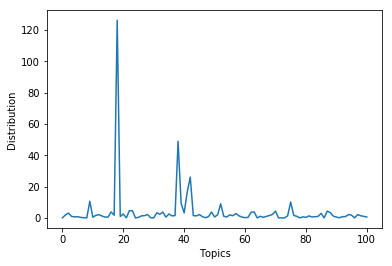

In [535]:
#Place holder for Sum of topic scores
TP_sum = np.zeros((num_topics,2))
# Topic Id in the 0-th element of the Matrix
TP_sum[:,0] = np.linspace(0, num_topics, num=num_topics, dtype=int)
# Sup of the topic score in the 1-st
TP_sum[:,1] = np.sum(TP, axis=0)


plt.plot(TP_sum[:,0],TP_sum[:,1]);
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.show()



In [536]:
# Sort TP_sum by columt 1 descending
#argsort returns indeces of an array sorted ascending, thus multiplying array to -1 to get oposite indeces
TP_sum_sorted = TP_sum[np.multiply(TP_sum[:, 1],-1).argsort()]

print("Top 5 topics:")
TP_sum_sorted [0:5,:]

Top 5 topics:


array([[  18.        ,  126.26221776],
       [  38.        ,   48.98112374],
       [  42.        ,   26.08556963],
       [  41.        ,   16.49361742],
       [   9.        ,   10.62092701]])

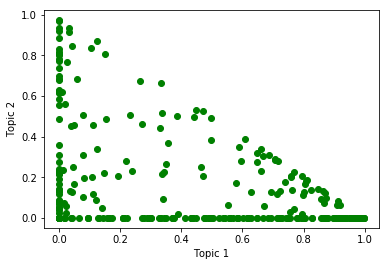

In [482]:
import matplotlib.pyplot as plt

plt.plot(TP[:,18],TP[:,38],'go')
#plt.scatter(TP[:,0],TP[:,1])
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.show()

## Ploating negative Data

In [470]:
# Placeholder for positive article - topic matrix
TN = np.zeros((mn,num_topics))

In [471]:
unreleasedTexts = extractTexts(N[:,1])

In [472]:
#Iterating over article tokens, extracting topics
for i in range(0,mn):
    #Extracting term vector
    ques_vec = dictionary.doc2bow(unreleasedTexts[i])
    #Extracting topic vectors
    topic_vec = ldamodel[ques_vec]
    for topic in topic_vec:
        # Populate elements of positive article-topic matrix
        TN[i,topic[0]] = topic[1]

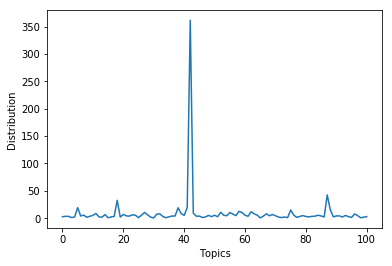

In [503]:
#Place holder for Sum of topic scores
TN_sum = np.zeros((num_topics,2))
# Topic Id in the 0-th element of the Matrix
TN_sum[:,0] = np.linspace(0, num_topics, num=num_topics, dtype=int)
# Sup of the topic score in the 1-st
TN_sum[:,1] = np.sum(TN, axis=0)


plt.plot(TN_sum[:,0],TN_sum[:,1]);
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.show()



In [524]:
# Sort TN_sum by columt 1 descending
#argsort returns indeces of an array sorted ascending, thus multiplying array to -1 to get oposite indeces
TN_sum_sorted = TN_sum[np.multiply(TN_sum[:, 1],-1).argsort()]

print("Top 5 topics:")
TN_sum_sorted [0:5,:]

Top 5 topics


array([[  42.        ,  361.70823291],
       [  87.        ,   42.51883068],
       [  18.        ,   32.69949561],
       [  41.        ,   19.3988822 ],
       [   5.        ,   19.31865912]])

In [595]:
TP_sum_sorted[28]

array([ 28.        ,   2.15682413])

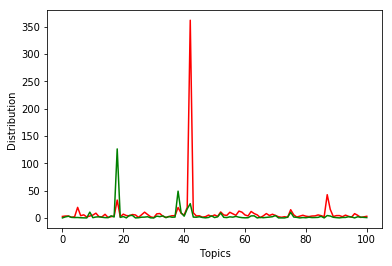

In [597]:
plt.plot(TN_sum[:,0],TN_sum[:,1],'r');
plt.plot(TP_sum[:,0],TP_sum[:,1],'g');
#plt.axis([0, 20, 0, 40])
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.show()

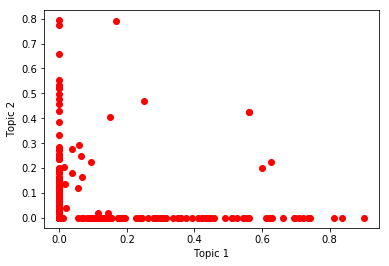

In [483]:
plt.plot(TN[:,18],TN[:,38],'ro')
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.show()

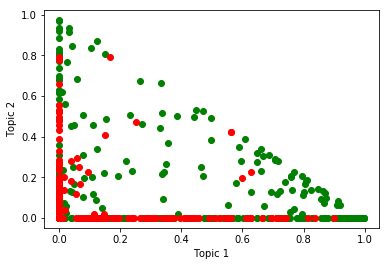

In [484]:
plt.plot(TP[:,18],TP[:,38],'go')
plt.plot(TN[:,18],TN[:,38],'ro')
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.show()

In [588]:
from mpl_toolkits.mplot3d import Axes3D

def plotTopics3D(tpos,tneg,rotation):
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.scatter(tpos[0],tpos[1],tpos[2])
    ax.scatter(tneg[0],tneg[1],tneg[2])

    ax.set_xlabel('Topic 1')
    ax.set_ylabel('Topic 2')
    ax.set_zlabel('Topic 3')
    
    ax.azim = rotation
    plt.show()

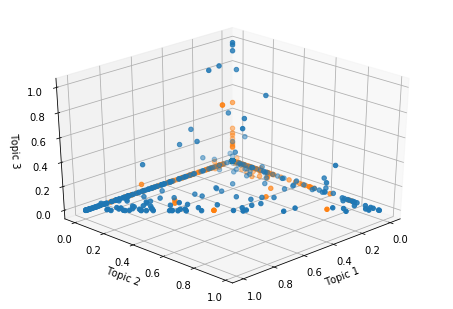

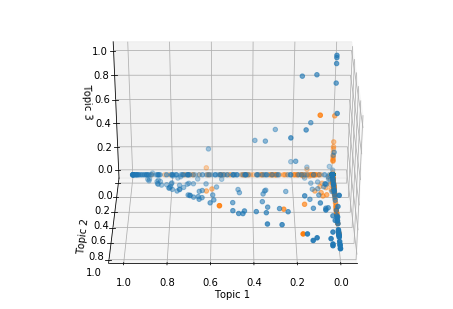

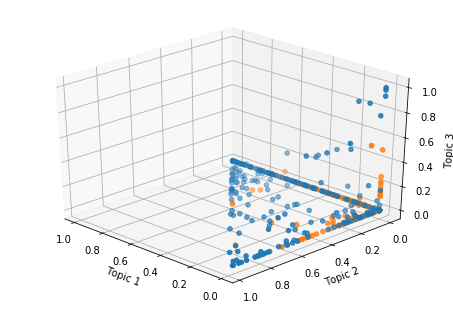

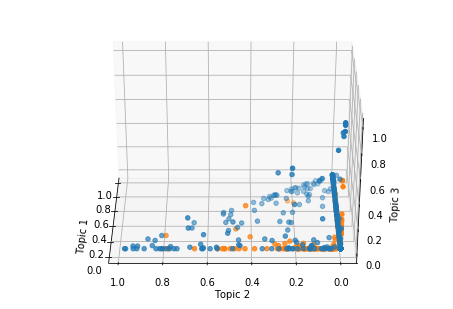

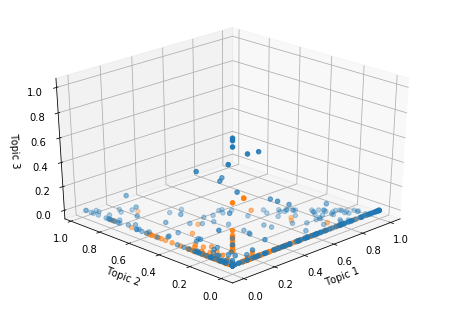

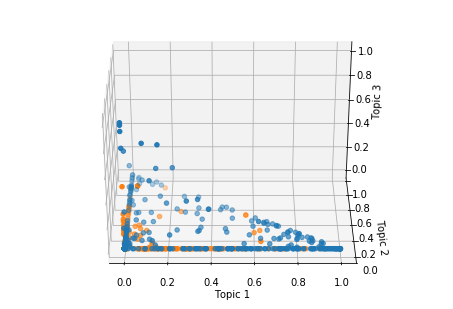

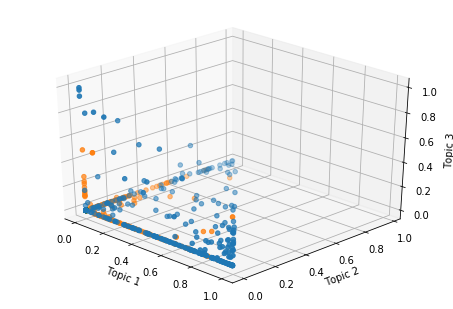

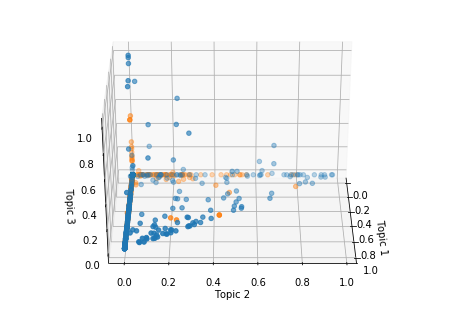

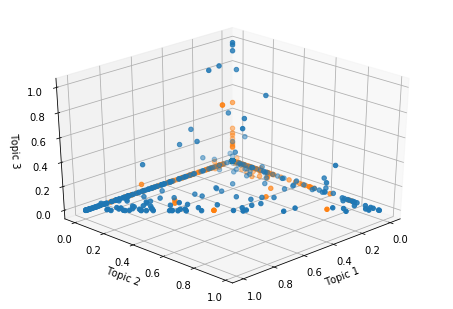

In [599]:

rot = 0
while rot <= 360 : 
    rot = rot + 45
    plotTopics3D([TP[:,18],TP[:,38],TP[:,9]],[TN[:,18],TN[:,38],TN[:,9]],rot)